<a href="https://colab.research.google.com/github/heerboi/AI-from-scratch/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor


In [2]:
train_data = torchvision.datasets.CIFAR100('./cifar100/', download=True, train=True, transform=ToTensor())
test_data = torchvision.datasets.CIFAR100('./cifar100/', download=True, train=False, transform=ToTensor())


100%|██████████| 169M/169M [00:06<00:00, 26.8MB/s]


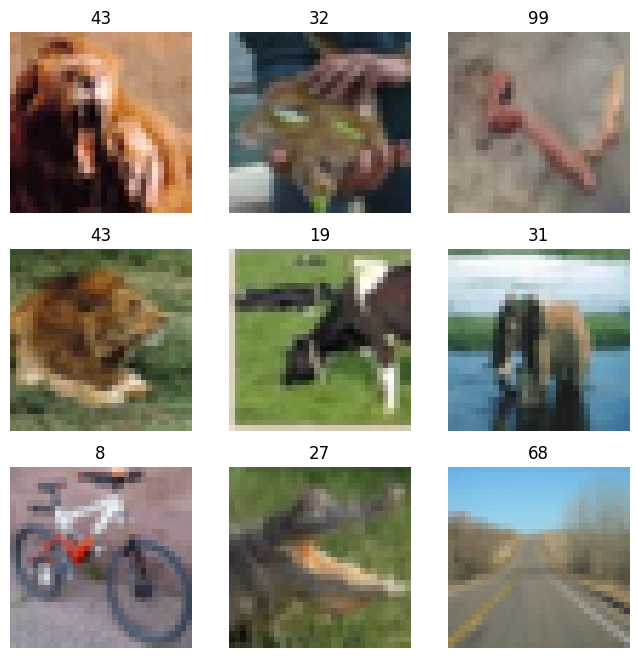

In [3]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(torch.einsum("c h w -> h w c", img))

plt.show()

capsicom!

In [4]:
# patch dims = P * P
P = 8

C, H, W = train_data[0][0].shape
N = H * W // P**2

print(f"{N} patches with height width {P} x {P}")

16 patches with height width 8 x 8


In [5]:
x = torch.arange(16)
x = x.view(1, 1, 4, 4)
x

tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]])

In [6]:
x.unfold(2,2,2).unfold(3,2,2)

tensor([[[[[[ 0,  1],
            [ 4,  5]],

           [[ 2,  3],
            [ 6,  7]]],


          [[[ 8,  9],
            [12, 13]],

           [[10, 11],
            [14, 15]]]]]])

In [7]:
x.unfold(2,2,2).unfold(3, 2, 2).reshape(1,1,-1,2,2)

tensor([[[[[ 0,  1],
           [ 4,  5]],

          [[ 2,  3],
           [ 6,  7]],

          [[ 8,  9],
           [12, 13]],

          [[10, 11],
           [14, 15]]]]])

In [8]:
def create_patches(imgs, P):

    # imgs is of shape (B, C, H, W)
    # gotta convert to (B, N, C, P, P)

    B, C, H, W = imgs.shape

    # take patches of size P along the rows
    imgs = imgs.unfold(2, P, P)
    # rearrange to "transpose" the pixels into correct order
    imgs = imgs.unfold(3, P, P)

    imgs = torch.einsum("b c a d h w -> b a d c h w",imgs)
    imgs = imgs.reshape(B,-1, C, P, P)

    return imgs

In [9]:
sample_idx = torch.randint(len(train_data), size=(1,)).item()
img, label = train_data[sample_idx]
img = img.view(1, *img.shape)
print(img.shape)

patches = create_patches(img, P)
# 16 patches of 8x8
patches[0].shape

torch.Size([1, 3, 32, 32])


torch.Size([16, 3, 8, 8])

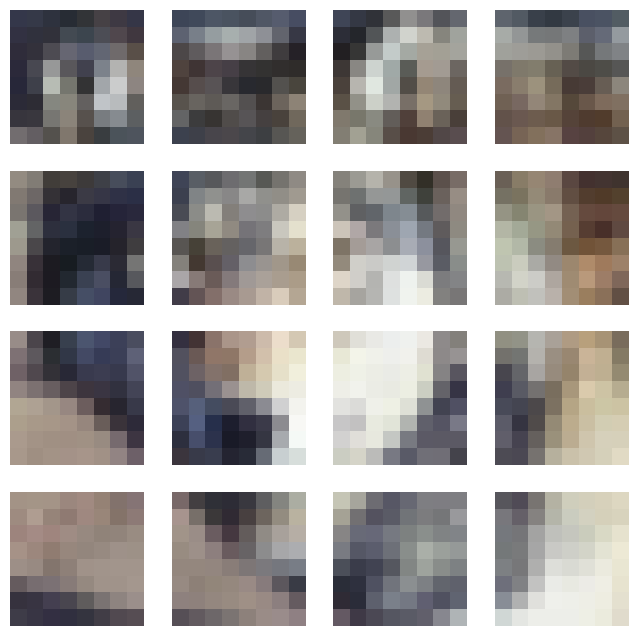

In [10]:
figure = plt.figure(figsize=(8,8))
cols, rows = 4,4
for i in range(0, cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(torch.einsum("c h w -> h w c", patches[0][i]))

plt.show()

In [11]:
D = 512
E = nn.Linear(P**2 * C, D)
E_pos = nn.Embedding(num_embeddings=N+1, embedding_dim=D)
cls_token = nn.Parameter(torch.randn(1, 1, D))

In [12]:
patches_flat = patches.view(*patches.shape[:-3], -1)

In [13]:
patches_flat.shape

torch.Size([1, 16, 192])

In [14]:
E_pos(torch.arange(patches.shape[1])).shape

torch.Size([16, 512])

In [15]:
def forward(x):
    B, N, P_2_C = x.shape

    x = E(x)
    x = torch.cat([cls_token.expand(B, -1, -1), x], dim=1) + E_pos(torch.arange(N+1))

    return x

In [16]:
forward(patches_flat).shape

torch.Size([1, 17, 512])

In [17]:
block_size = 17

In [59]:
class Attn(nn.Module):

    def __init__(self,n_embd, head_size):
        super().__init__()

        self.Q = nn.Linear(n_embd, head_size)
        self.K = nn.Linear(n_embd, head_size)
        self.V = nn.Linear(n_embd, head_size)
        self.head_size = head_size
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        # dim = (B, T, n_embd) -> (B, T, head_size)
        queries = self.Q(x)
        keys = self.K(x)
        values = self.V(x)

        # need (B, T, T)
        # affinity of token at each time step
        # (B, T, head_size) * (B, head_size, T) -> (B, T, T)
        weights = (keys @ torch.einsum("b t h -> b h t", queries)) / self.head_size**0.5

        weights = F.softmax(weights, dim=-1)

        # (B, T, T) * (B, T, head_size) = (B, T, head_size)
        x = weights @ values

        return x

In [35]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = [Attn(n_embd=n_embd, head_size=head_size) for _ in range(num_heads)]

        self.linear = nn.Linear(n_embd, n_embd)

    def forward(self, x):

        activations = [head(x) for head in self.heads]

        x = self.linear(torch.concat(activations, dim=-1))

        return x

In [69]:
class MLP(nn.Module):

    def __init__(self, in_features, hidden_size, out_features, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_size, bias=bias)
        self.linear2 = nn.Linear(hidden_size, out_features, bias=bias)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.linear2(self.relu(self.linear1(x)))

        # im not kidding i forgot this statement and then proceeded to lose my fucking mind
        return x


In [37]:
num_heads = 16
head_size = D // num_heads
hidden_size = 512
D = 512

In [95]:
class VIT(nn.Module):

    def __init__(self, n_categories, n_embd, num_heads, head_size, hidden_size, bias=True):

        super().__init__()
        self.E = nn.Linear(P**2 * C, D)
        self.E_pos = nn.Embedding(num_embeddings=N+1, embedding_dim=n_embd)
        self.cls_token = nn.Parameter(torch.randn(1, 1, n_embd))

        self.LN = nn.LayerNorm(n_embd)

        self.MHA = MultiHeadAttention(num_heads, n_embd, head_size)

        self.MLP = MLP(n_embd, hidden_size, n_embd, bias)

        self.catMLP = MLP(n_embd, hidden_size, n_categories, bias)

    def forward(self, x, targets=None):

        B, C, H, W = x.shape

        patches = create_patches(x, P)
        patches = patches.view(*patches.shape[:-3], -1)

        B, N, P_2_C = patches.shape

        embeddings = self.E(patches)

        # merge the 0th embedding on the time dimension
        # print(embeddings.shape)
        # print(self.cls_token.shape)
        final_embd = torch.cat([self.cls_token, embeddings], dim=1) + self.E_pos(torch.arange(N+1))

        final_embd = self.LN(final_embd)

        attn = self.LN(self.MHA(final_embd) + final_embd)

        act = self.MLP(attn) + attn

        # print(act)
        # print(act.shape)

        first_embd = act[:, 0, :]
        # print(first_embd)
        # print(first_embd.shape)

        logits = self.catMLP(first_embd)

        if targets == None:
                    loss = None
        else:
            targets = targets.view(-1)

            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def predict(self, x):

        logits, loss = self(x)

        probs = F.softmax(logits, dim=1)

        top_k = torch.multinomial(probs, num_samples=5)

        return top_k


In [96]:
model = VIT(100, D, num_heads, head_size, hidden_size)

In [93]:
logits, loss = model(img, torch.tensor(label))

In [99]:
probs = model.predict(img)
probs, label

(tensor([[29, 56, 70, 28, 60]]), 97)